# Transformer Encoder for Transfomer Neural Network

In [1]:
import torch
import math
from torch import nn
import torch.nn.functional as F
from IPython.display import Image

In [2]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        print(f"-- ADDING MASK of shape {mask.size()} --") 
        # Broadcasting add. So just the last N dimensions need to match
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta
        print(f"self.gamma: {self.gamma.size()}, self.beta: {self.beta.size()}")
        print(f"out: {out.size()}")
        return out

  
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        print(f"x after 2nd linear layer: {x.size()}")
        return x


class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        residual_x = x
        print("------- ATTENTION 1 ------")
        x = self.attention(x, mask=None)
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x)
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x)
        residual_x = x
        print("------- ATTENTION 2 ------")
        x = self.ffn(x)
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x)
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x)
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                     for _ in range(num_layers)])

    def forward(self, x):
        x = self.layers(x)
        return x

d_model is the size of the vector thought out the encoder architecture

In [3]:
d_model = 512

num_heads usually used in multihead attention which means when performing multihead attention , we are going to perform it 8 times in parallel
here will be 8 operations will be performed simulteneously with softmax and perform with respect to attention

Consider it as performing parallise operations within encoder

In [4]:
num_heads = 8

throughout the encoder we are going to perform something called dropout where randomly turn off certain neurons which will force it to learn along different paths in networks

instead of memorizing the data it will help to generalised the data better

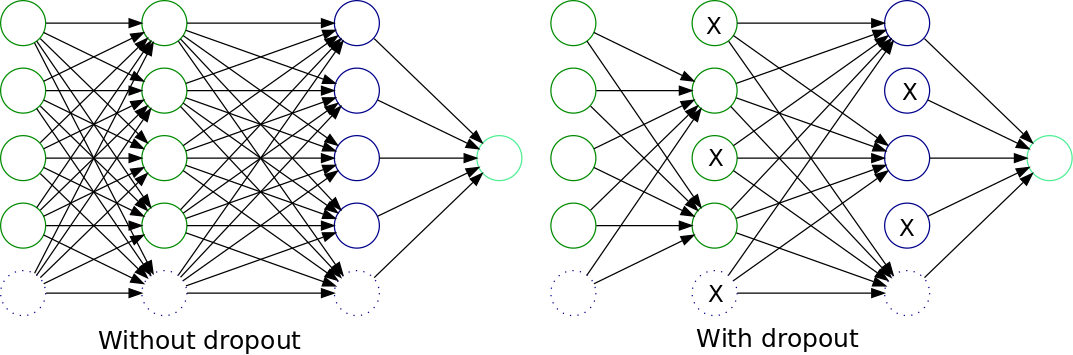

In [5]:
drop_prob = 0.1 # 10% chance that given neurons will be turned off on a given stage

We are dealing with neural network and we want to perform some training typically we would pass in multiple examples at the same time those multiple examples constitute a batch so its faster training and makes more stable 

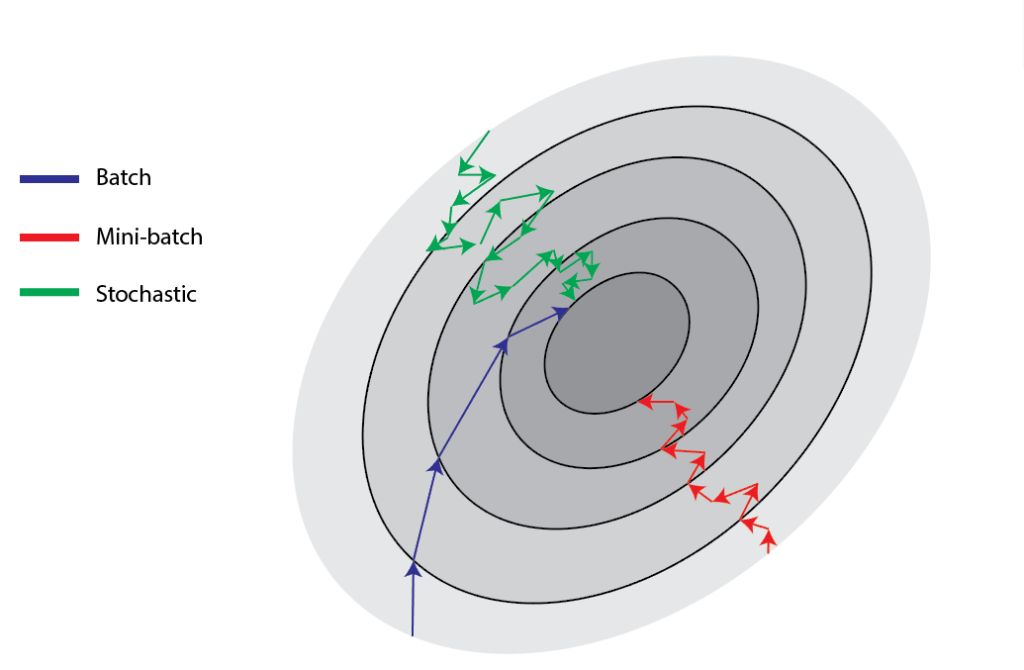

In [6]:
batch_size = 30
max_sequence_length = 200 #largest number of words can be passed at a time to encoder for translation  

we have feed forward before and after the normalizational layer. which is used to expand the number of neurons for vectors at some points to 2048 before making it to back down to 512 in normalizational layer. This is just to learn some additional information if and while we can like any other feed forward layer is design to do

In [7]:
ffn_hidden = 2048

num_layers is the number of Transfomer encoder units that we want to include in our architecture 

In [8]:
num_layers = 5

In [9]:
encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)

In [10]:
x = torch.randn( (batch_size, max_sequence_length, d_model) ) # includes positional encoding
out = encoder(x)

------- ATTENTION 1 ------
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv.size(): torch.Size([30, 200, 8, 192])
qkv.size(): torch.Size([30, 8, 200, 192])
q size: torch.Size([30, 8, 200, 64]), k size: torch.Size([30, 8, 200, 64]), v size: torch.Size([30, 8, 200, 64]), 
scaled.size() : torch.Size([30, 8, 200, 200])
values.size(): torch.Size([30, 8, 200, 64]), attention.size:torch.Size([30, 8, 200, 200]) 
values.size(): torch.Size([30, 200, 512])
out.size(): torch.Size([30, 200, 512])
------- DROPOUT 1 ------
------- ADD AND LAYER NORMALIZATION 1 ------
Mean (torch.Size([30, 200, 1]))
Standard Deviation  (torch.Size([30, 200, 1]))
y: torch.Size([30, 200, 512])
self.gamma: torch.Size([512]), self.beta: torch.Size([512])
out: torch.Size([30, 200, 512])
------- ATTENTION 2 ------
x after first linear layer: torch.Size([30, 200, 2048])
x after activation: torch.Size([30, 200, 2048])
x after dropout: torch.Size([30, 200, 2048])
x after 2nd linear layer: torch.